In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt

In [4]:
from scipy import signal


def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

## Carregando o Dataset

In [5]:
caminhos = [os.path.join("src", nome) for nome in os.listdir("src")]
print(caminhos)

['src/1_EMG_Danilo_02-12-2019_201601.npy']


In [6]:
dataset = [np.load(gesture) for gesture in caminhos]
dataset = np.array(dataset)

dataset = dataset.swapaxes(2,3)
print(dataset.shape)
print(dataset[0,0,0])

(1, 5, 4, 2000)
[16.894999  19.08471   15.789858  ...  4.7665024 27.880955  30.755068 ]


### Gesto , tentativas , eletrodos, dados

## Plotting

In [17]:
def filtering (dataset):
    
    
    for i in range(dataset.shape[1]):
        plt.plot(dataset[3,i,:])
    plt.show()
    data_filtered = []
    print(dataset.shape)
    
    data_filtered = butter_notch(dataset, 60)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[3,i,:])
    plt.show()
    data_filtered = butter_highpass(data_filtered, 5)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[3,i,:])
    plt.show()
    data_filtered = butter_lowpass(data_filtered, 50)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[3,i,:])
    plt.show()
    
    return data_filtered


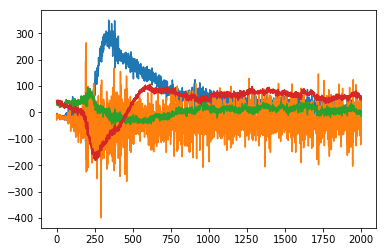

(5, 4, 2000)


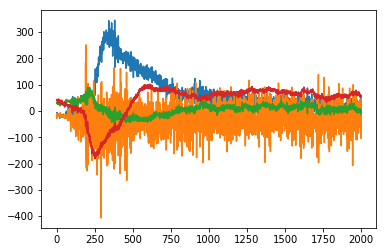

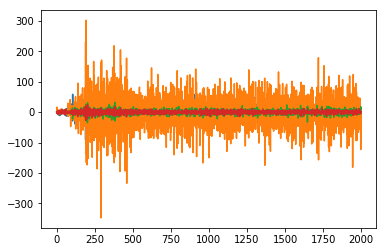

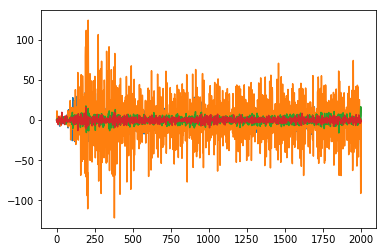

In [19]:
data_filtered = filtering(dataset[0])

## Segmentação

In [22]:
salto = 20
segmento = 100
print(data_filtered.shape)
n_win = int((data_filtered.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x = np.array([data_filtered[:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 0, 3)
print(x.shape)



(5, 4, 2000)
(5, 4, 96, 100)


## Domínio do Tempo

#### VAR

In [24]:
var = np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)
print(var.shape)

(5, 4, 96)


#### RMS

In [26]:
rms = np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1))
print(rms.shape)

(5, 4, 96)


#### MAV

In [ ]:
def vaiSVC(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, shuffle=True)


    for kernel in ['rbf']:#, 'linear']:
        for gamma in [0.001, 0.01, 0.1]:
            for C in [1, 10, 100, 1000]:
                classificador = []
                classificador = svm.SVC(gamma=gamma, C=C, kernel=kernel).fit(X_train, y_train)
                print('acuracia:', (classificador.score(X_test, y_test)) * 100, 'kernel:', kernel, 'gamma:', gamma, 'C:', C)
            

    cls = []
    cls = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', n_components=7).fit(X_train, y_train)
    print('\n acuracia:', cls.score(X_test, y_test) * 100)